In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

In [5]:
# 1. READ CSV
file_path = r"Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv"
df = pd.read_csv(file_path)

# 2. PARSE DATE & SORT
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)

# 3. DEFINE SERVICE COLUMNS
service_cols = ['Local Route', 'Light Rail', 'Peak Service',
                'Rapid Route', 'School', 'Other']

In [20]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")


In [6]:
# Basic information
print(df.info())

# Peek at the data
print(df.head())

# Check missingness
print(df.isna().mean().sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1918 non-null   datetime64[ns]
 1   Local Route   1918 non-null   int64         
 2   Light Rail    1918 non-null   int64         
 3   Peak Service  1918 non-null   int64         
 4   Rapid Route   1918 non-null   int64         
 5   School        1918 non-null   int64         
 6   Other         1898 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 105.0 KB
None
        Date  Local Route  Light Rail  Peak Service  Rapid Route  School  \
0 2019-07-01        15987        9962           407        21223    3715   
1 2019-07-02        16895       10656           409        21715    3993   
2 2019-07-03        16613       10658           427        22025    3638   
3 2019-07-04        16604       10445           437        21868

In [24]:
# Force daily frequency
df = df.asfreq("D")

# Interpolate missing
df = df.interpolate(method="time").ffill().bfill()

print("Missing values after cleaning:\n", df.isna().sum())

Missing values after cleaning:
 Local Route      0
Light Rail       0
Peak Service     0
Rapid Route      0
School           0
Other            0
Total            0
Year             0
Month            0
weekday          0
is_school_day    0
Day              0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1896\3137485288.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method="time").ffill().bfill()


In [7]:
# 1. Total ridership per day
df['Total'] = df[service_cols].sum(axis=1, skipna=True)

# 2. Time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['weekday'] = df['Date'].dt.day_name()
df['is_school_day'] = df['School'] > 0


In [8]:
summary = df[service_cols + ['Total']].describe().T
summary['cv'] = summary['std'] / summary['mean']  # coefficient of variation
print(summary)

               count          mean           std  min       25%      50%  \
Local Route   1918.0   9891.395203   6120.715714  1.0   3044.50  11417.0   
Light Rail    1918.0   7195.446298   3345.616428  0.0   4463.50   7507.0   
Peak Service  1918.0    179.581335    156.532738  0.0      0.00    193.0   
Rapid Route   1918.0  12597.213243   6720.494557  0.0   6383.00  13106.5   
School        1918.0   2352.694995   2494.766306  0.0      0.00    567.5   
Other         1898.0     43.390411     41.746882  0.0     14.00     40.0   
Total         1918.0  32259.269030  18147.879145  4.0  14043.75  34855.5   

                   75%      max        cv  
Local Route   15517.50  21070.0  0.618792  
Light Rail    10008.25  15154.0  0.464963  
Peak Service    313.75   1029.0  0.871654  
Rapid Route   17924.75  28678.0  0.533491  
School         4914.00   7255.0  1.060387  
Other            68.00   1105.0  0.962122  
Total         48301.50  69752.0  0.562563  


       Local Route  Light Rail  Peak Service  Rapid Route  School  Other  \
Month                                                                      
1           7238.0      6026.0         143.0      10121.0    49.0   32.0   
2          12771.0      8840.0         223.0      15673.0  4130.0   54.0   
3          11671.0      8122.0         210.0      14690.0  3476.0   54.0   
4           8107.0      6312.0         154.0      10724.0  1298.0   42.0   
5          10168.0      7090.0         181.0      12286.0  2954.0   54.0   
6           9871.0      7054.0         176.0      12116.0  2889.0   42.0   
7          10096.0      7559.0         198.0      13161.0  1858.0   41.0   
8          10881.0      7526.0         192.0      13647.0  3044.0   44.0   
9           9195.0      6621.0         166.0      11783.0  2299.0   39.0   
10          9346.0      6872.0         169.0      12309.0  2087.0   39.0   
11         11071.0      7763.0         201.0      13694.0  3313.0   46.0   
12          

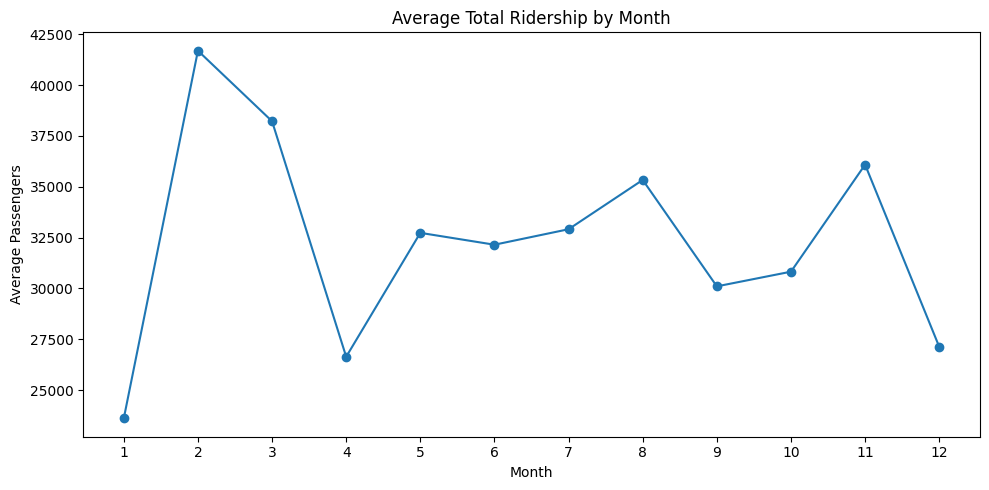

In [9]:
monthly = df.groupby('Month')[service_cols + ['Total']].mean().round(0)
print(monthly)

plt.figure(figsize=(10,5))
plt.plot(monthly.index, monthly['Total'], marker='o')
plt.xticks(range(1, 13))
plt.title("Average Total Ridership by Month")
plt.xlabel("Month")
plt.ylabel("Average Passengers")
plt.tight_layout()
plt.show()


In [10]:
weekday_mean = df.groupby('weekday')[service_cols + ['Total']].mean().round(0)
print(weekday_mean.sort_values('Total'))


           Local Route  Light Rail  Peak Service  Rapid Route  School  Other  \
weekday                                                                        
Sunday          2192.0      3588.0           0.0       5053.0     0.0   18.0   
Saturday        3271.0      5001.0           0.0       6641.0     0.0   19.0   
Monday         11445.0      7542.0         236.0      13859.0  3014.0   44.0   
Friday         12544.0      8510.0         203.0      14942.0  3126.0   55.0   
Thursday       13167.0      8515.0         255.0      15740.0  3370.0   58.0   
Tuesday        13243.0      8592.0         282.0      15950.0  3454.0   52.0   
Wednesday      13379.0      8620.0         282.0      15996.0  3504.0   56.0   

             Total  
weekday             
Sunday     10851.0  
Saturday   14932.0  
Monday     36139.0  
Friday     39379.0  
Thursday   41105.0  
Tuesday    41572.0  
Wednesday  41836.0  


In [11]:
# Share of total ridership
service_share = df[service_cols].sum() / df['Total'].sum()
print("Service share of total ridership:\n", service_share.round(3))

# Correlation with Total
corr_with_total = df[service_cols + ['Total']].corr()['Total'].sort_values(ascending=False)
print("\nCorrelation with Total:\n", corr_with_total)


Service share of total ridership:
 Local Route     0.307
Light Rail      0.223
Peak Service    0.006
Rapid Route     0.390
School          0.073
Other           0.001
dtype: float64

Correlation with Total:
 Total           1.000000
Local Route     0.990457
Rapid Route     0.986948
Light Rail      0.955443
Peak Service    0.940254
School          0.837976
Other           0.444682
Name: Total, dtype: float64


In [12]:
school_day_mean = df.groupby('is_school_day')[service_cols + ['Total']].mean().round(0)
print(school_day_mean)


               Local Route  Light Rail  Peak Service  Rapid Route  School  \
is_school_day                                                               
False               4790.0      5021.0          68.0       7793.0     0.0   
True               14411.0      9122.0         278.0      16854.0  4437.0   

               Other    Total  
is_school_day                  
False           25.0  17697.0  
True            59.0  45161.0  


In [13]:
# Check missingness and distribution
print("Missing fraction in 'Other':", df['Other'].isna().mean())

# Top 5 'Other' days
top_other = df.nlargest(5, 'Other')[['Date'] + service_cols + ['Total']]
print(top_other)

Missing fraction in 'Other': 0.010427528675703858
           Date  Local Route  Light Rail  Peak Service  Rapid Route  School  \
1040 2022-05-06        12690        8920           162        13686    3786   
1241 2022-11-23        14492        9646           266        16659    3916   
118  2019-10-27         3020        5112             0         6761       0   
1512 2023-08-21        15616       10487           364        19386    4704   
639  2021-03-31        16718        9942           294        18162    5493   

       Other    Total  
1040  1105.0  40349.0  
1241   176.0  45155.0  
118    171.0  15064.0  
1512   162.0  50719.0  
639    161.0  50770.0  


In [14]:
# Compare std and mean across main services
service_stats = df[['Rapid Route', 'Local Route', 'Light Rail']].agg(['mean','std']).T
service_stats['cv'] = service_stats['std'] / service_stats['mean']
print(service_stats)

# Weekly pattern for Rapid Route
rapid_weekday = df.groupby('weekday')['Rapid Route'].mean().round(0)
print(rapid_weekday.sort_values())


                     mean          std        cv
Rapid Route  12597.213243  6720.494557  0.533491
Local Route   9891.395203  6120.715714  0.618792
Light Rail    7195.446298  3345.616428  0.464963
weekday
Sunday        5053.0
Saturday      6641.0
Monday       13859.0
Friday       14942.0
Thursday     15740.0
Tuesday      15950.0
Wednesday    15996.0
Name: Rapid Route, dtype: float64


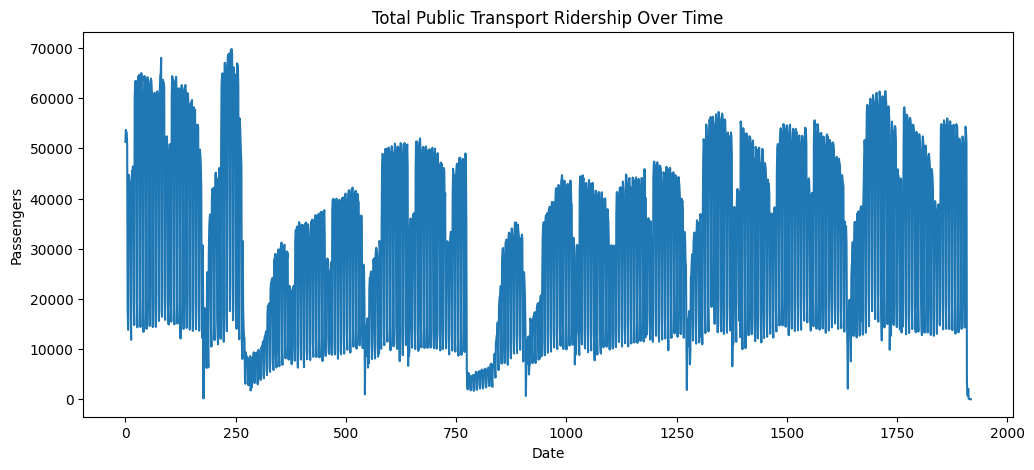

In [16]:
plt.figure(figsize=(12,5))
plt.plot(df["Total"])
plt.title("Total Public Transport Ridership Over Time")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.show()

<Figure size 1200x600 with 0 Axes>

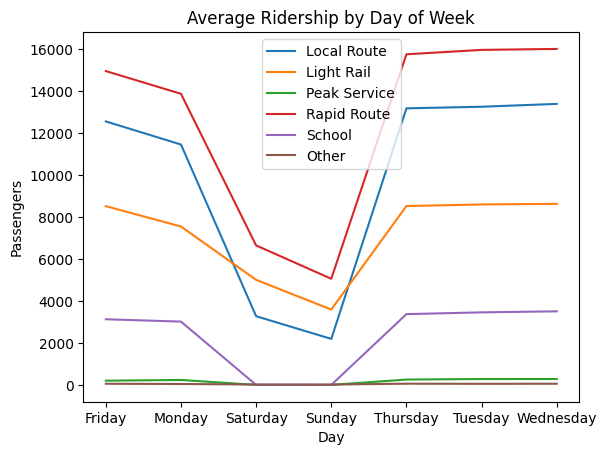

In [18]:
df["Day"] = df["Date"].dt.day_name()

weekday_avg = df.groupby("Day")[service_cols].mean()

plt.figure(figsize=(12,6))
weekday_avg.plot()
plt.title("Average Ridership by Day of Week")
plt.ylabel("Passengers")
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1896\1627010097.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df["Total"].resample("M").mean()


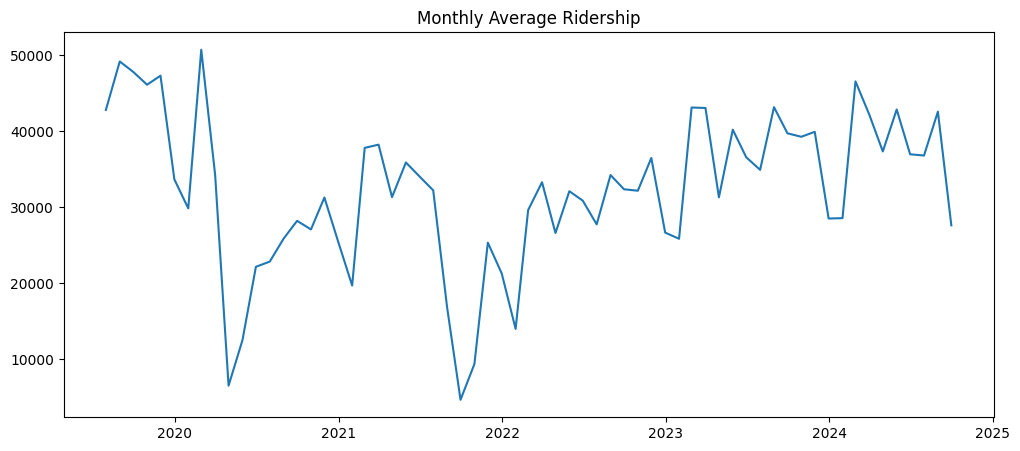

In [21]:
monthly = df["Total"].resample("M").mean()

plt.figure(figsize=(12,5))
plt.plot(monthly)
plt.title("Monthly Average Ridership")
plt.show()


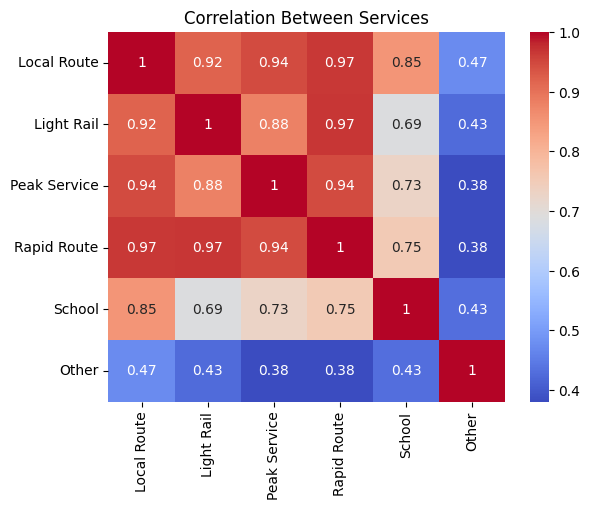

In [22]:
corr = df[service_cols].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Between Services")
plt.show()


Decomposing Local Route...


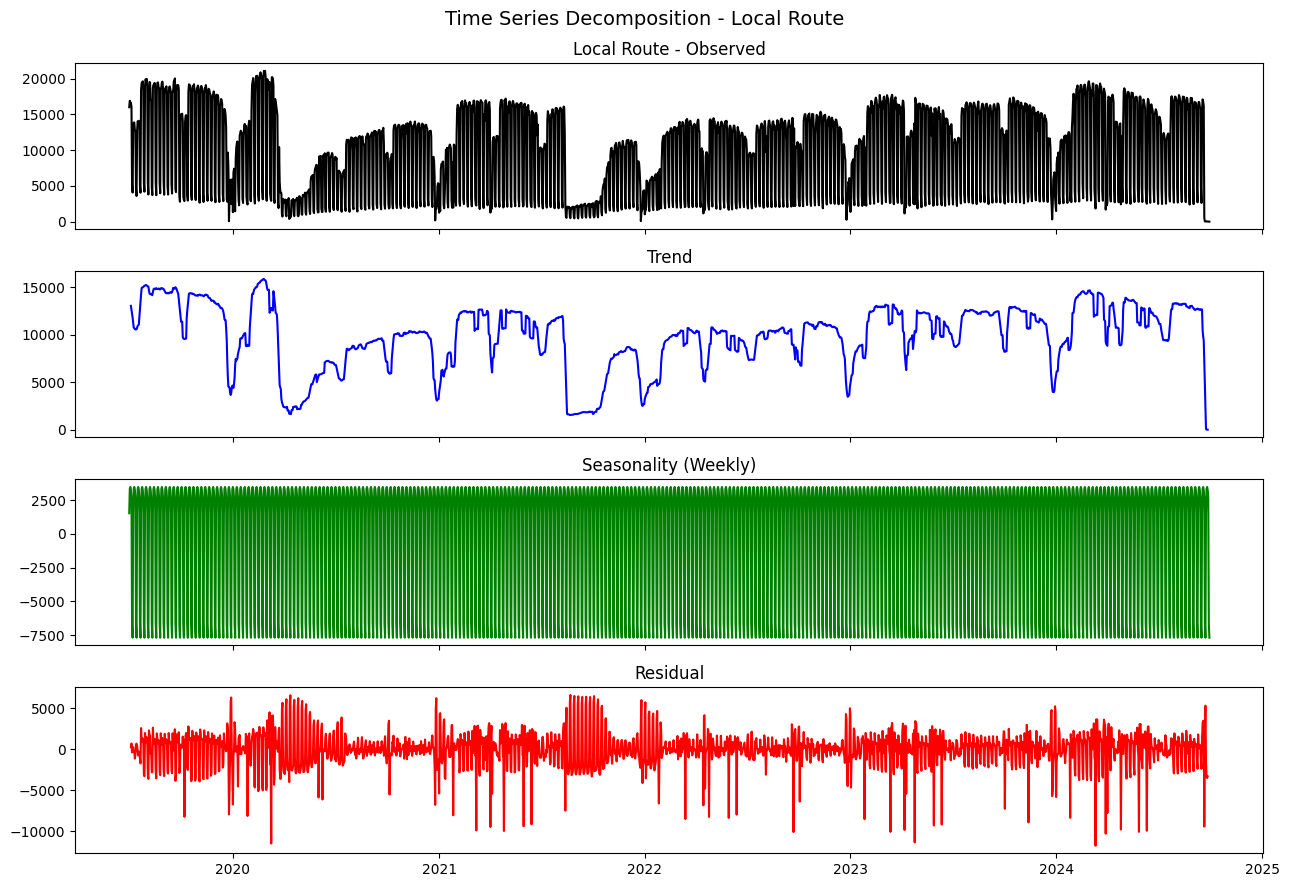

Decomposing Light Rail...


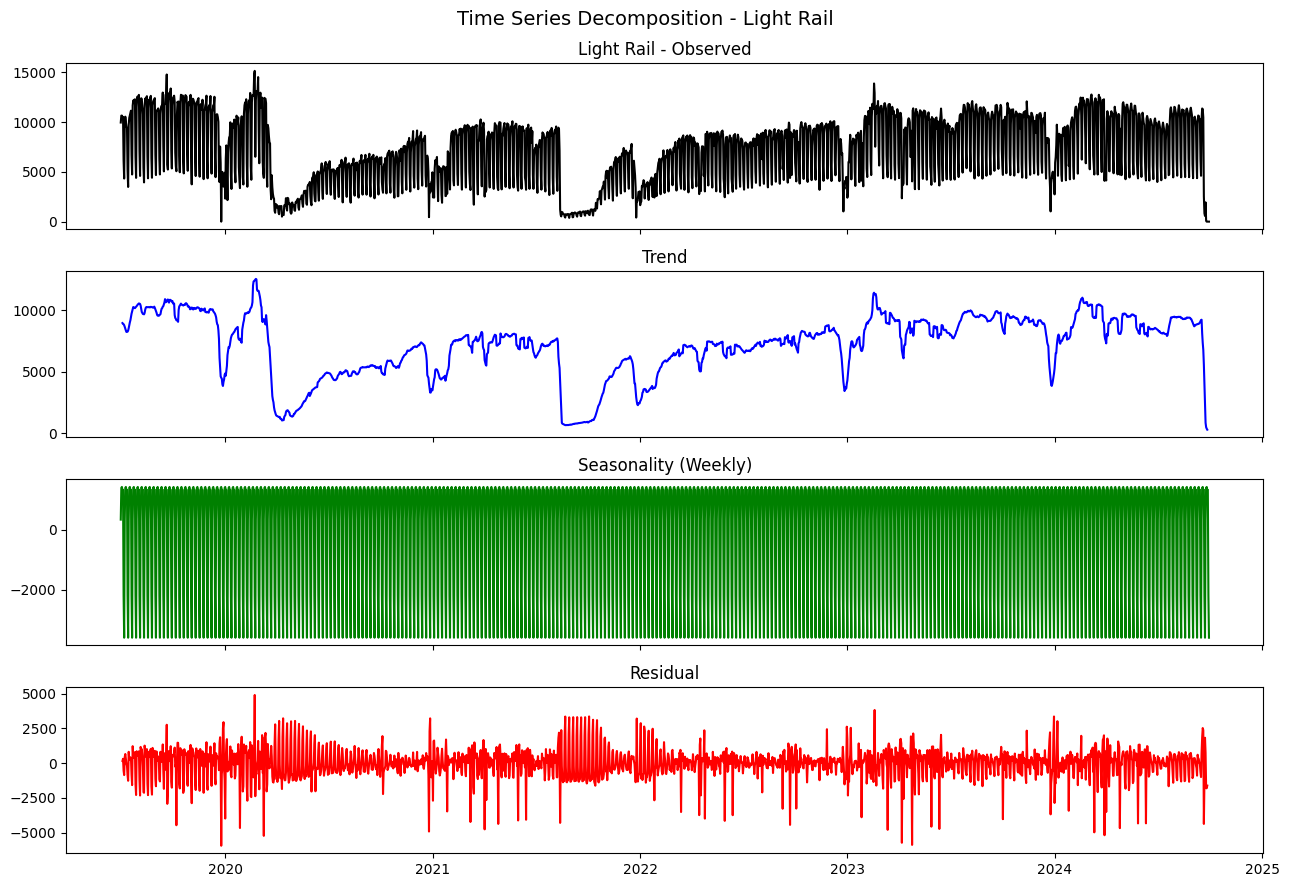

Decomposing Peak Service...


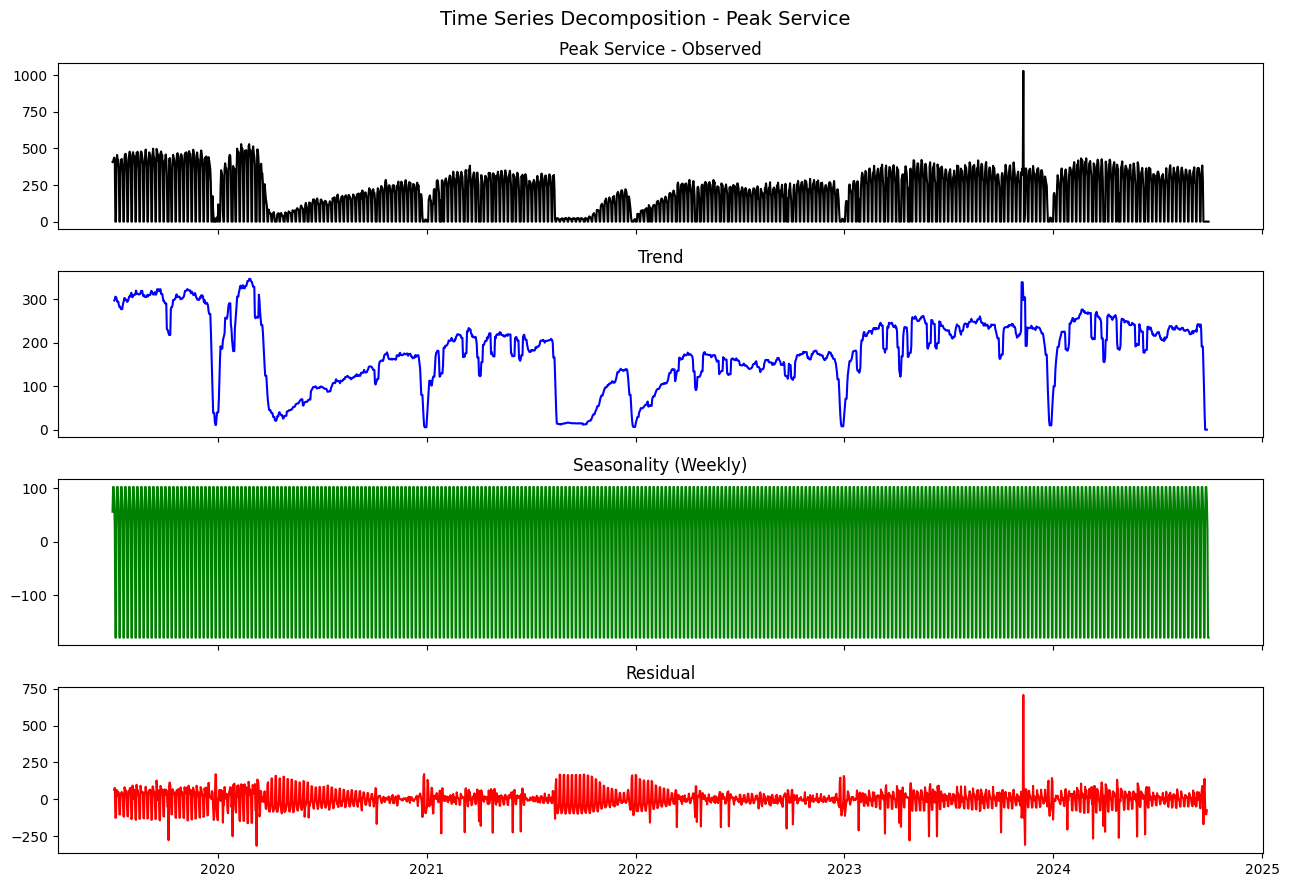

Decomposing Rapid Route...


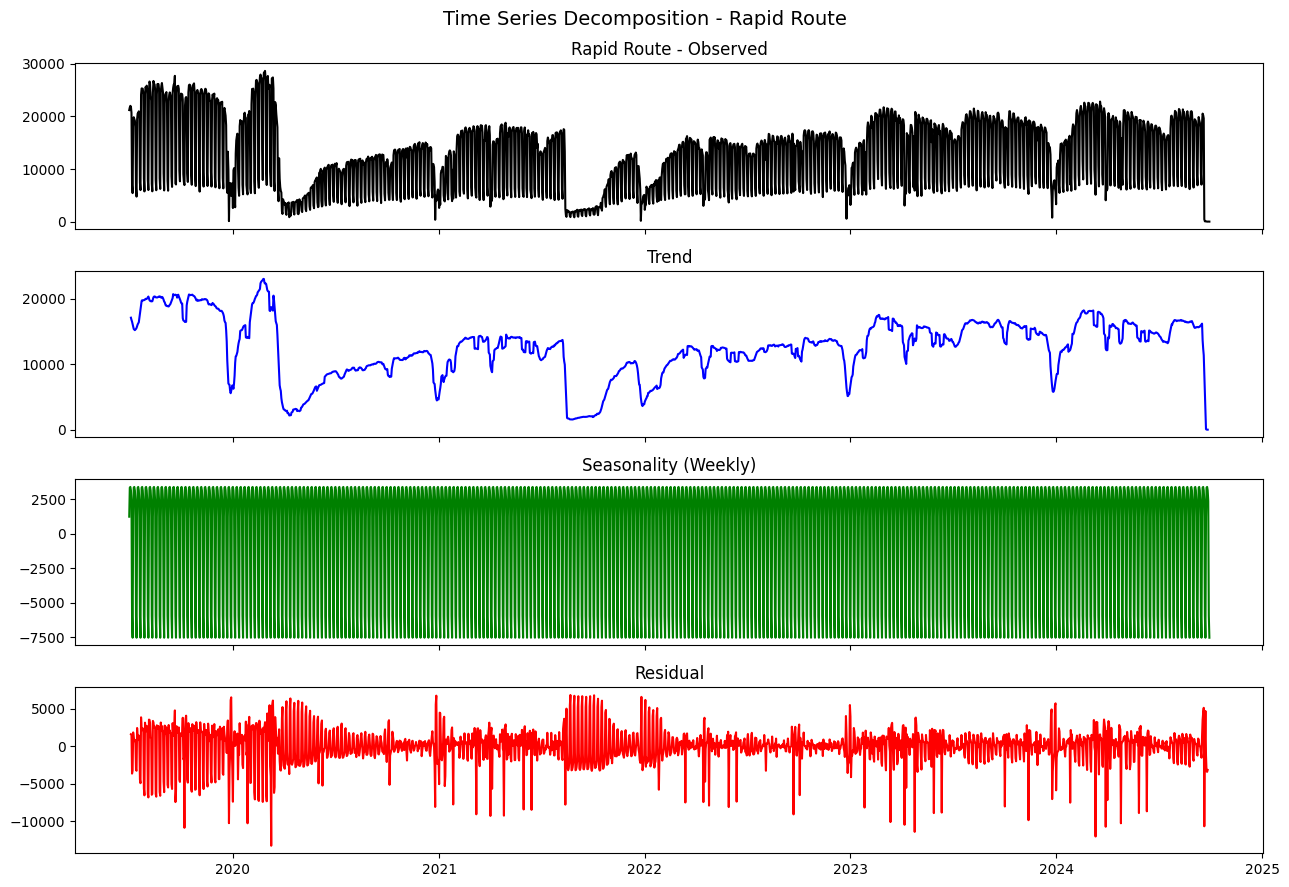

Decomposing School...


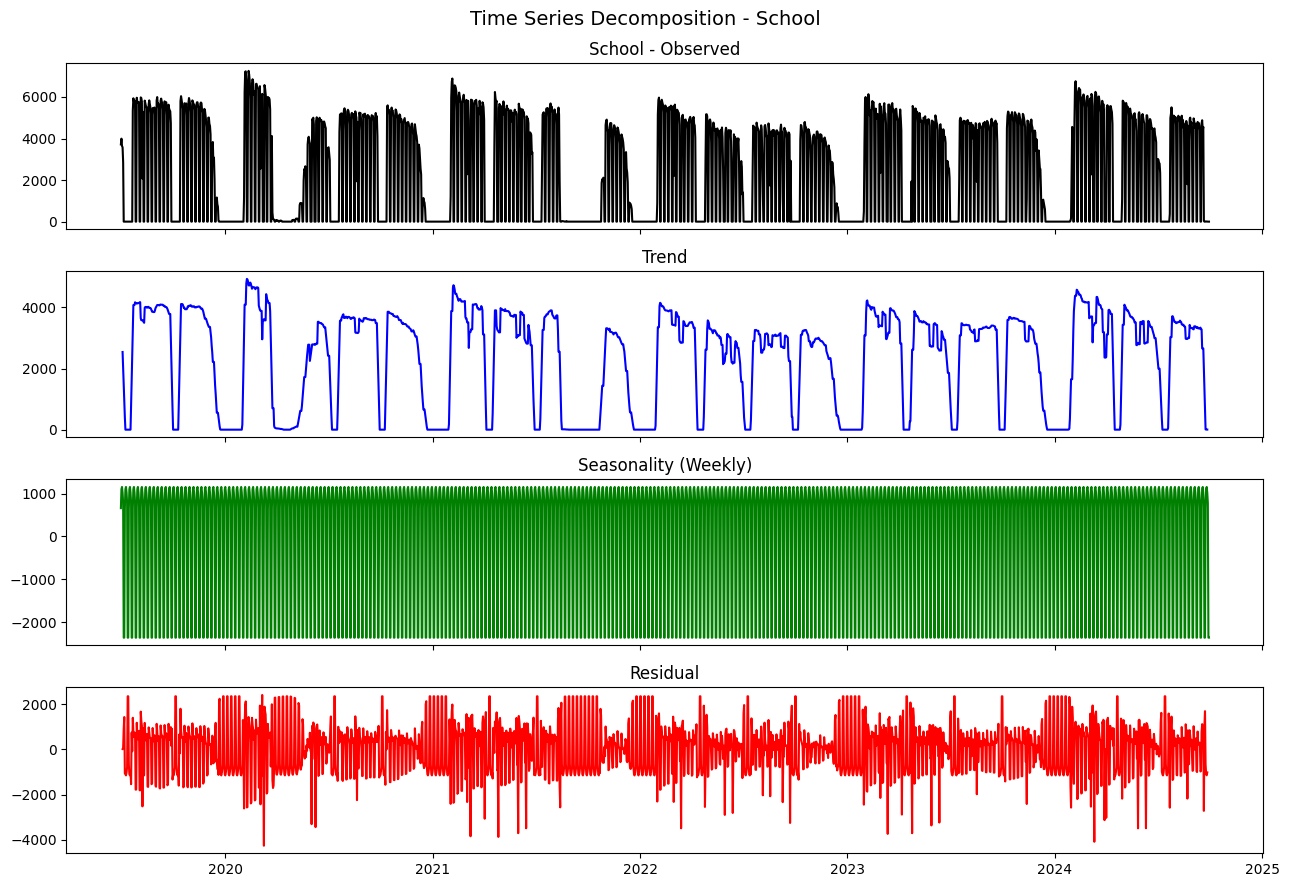

Decomposing Other...


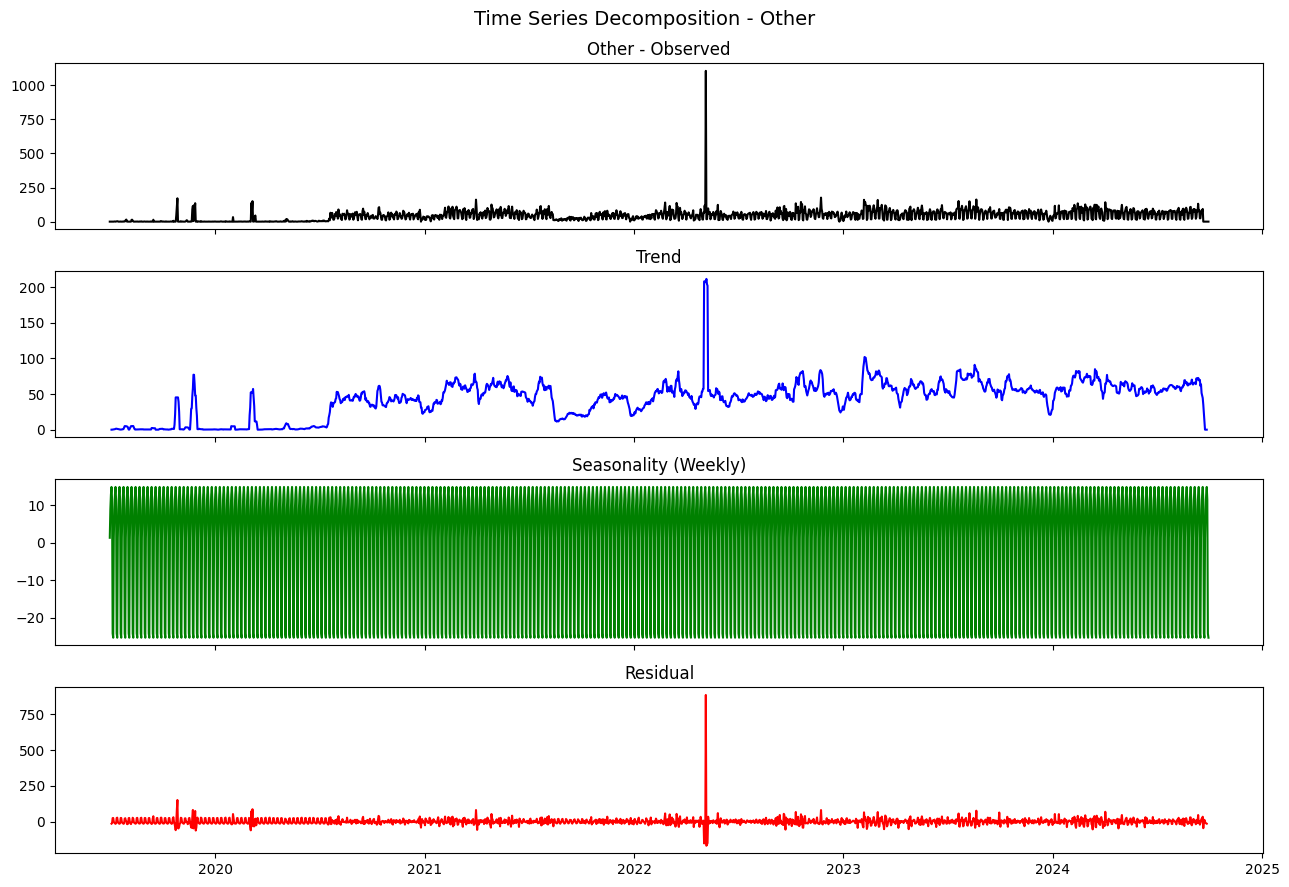

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

for service in service_cols:
    print(f"Decomposing {service}...")
    
    result = seasonal_decompose(
        df[service],
        model="additive",
        period=7   # weekly seasonality
    )
    
    fig, axes = plt.subplots(4, 1, figsize=(13, 9), sharex=True)
    
    # Original
    axes[0].plot(result.observed, color="black")
    axes[0].set_title(f"{service} - Observed")
    
    # Trend
    axes[1].plot(result.trend, color="blue")
    axes[1].set_title("Trend")
    
    # Seasonal
    axes[2].plot(result.seasonal, color="green")
    axes[2].set_title("Seasonality (Weekly)")
    
    # Residual
    axes[3].plot(result.resid, color="red")
    axes[3].set_title("Residual")
    
    plt.suptitle(f"Time Series Decomposition - {service}", fontsize=14)
    plt.tight_layout()
    plt.show()


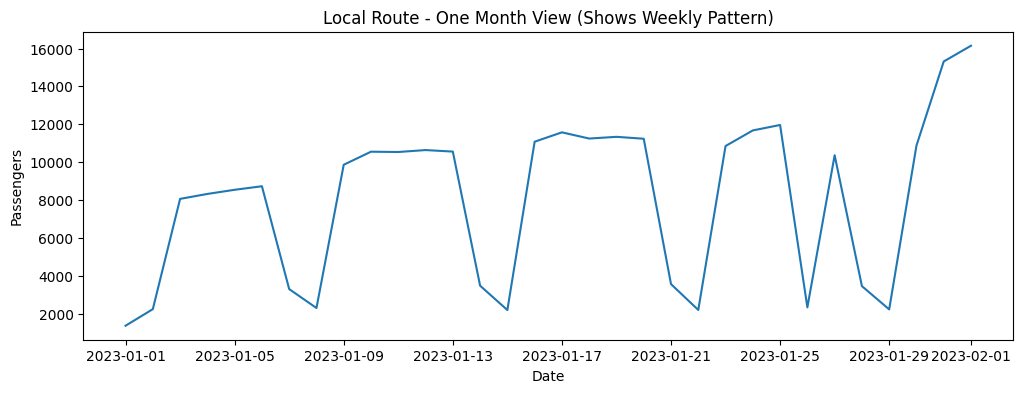

In [26]:
# Zoom into a sample range to see weekly repetition
sample = df["Local Route"]["2023-01-01":"2023-02-01"]

plt.figure(figsize=(12,4))
plt.plot(sample)
plt.title("Local Route - One Month View (Shows Weekly Pattern)")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.show()


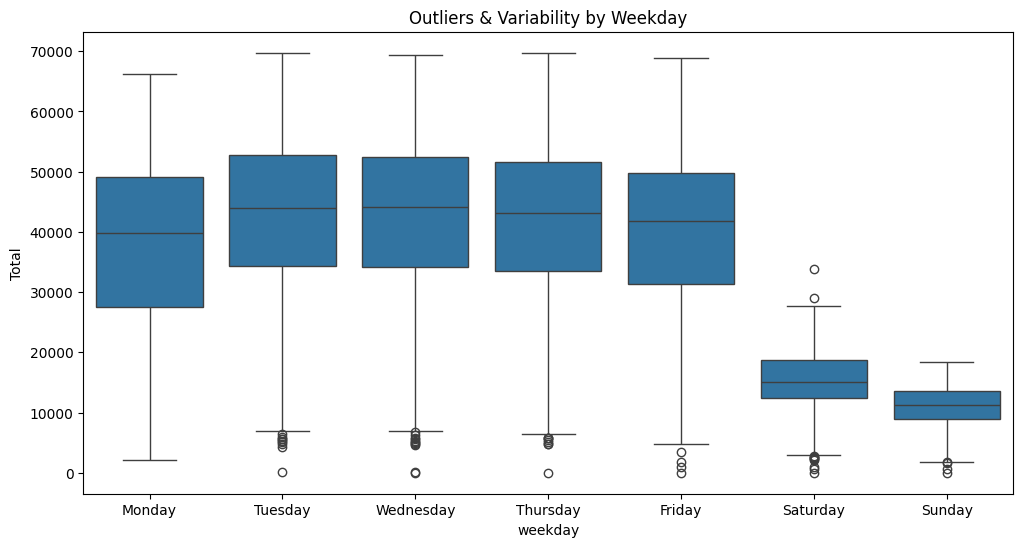

In [27]:
df["weekday"] = df.index.day_name()

plt.figure(figsize=(12,6))
sns.boxplot(x="weekday", y="Total", data=df,
            order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Outliers & Variability by Weekday")
plt.show()


In [28]:
# Convert all columns to numeric safely
df = df.apply(pd.to_numeric, errors="coerce")


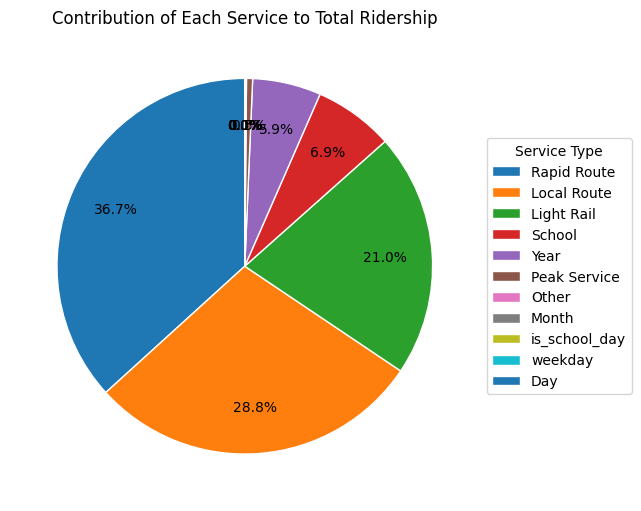

In [29]:
import matplotlib.pyplot as plt

# Make sure only service columns are used
service_cols = df.columns.drop("Total", errors="ignore")
contribution = df[service_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(6.5, 6.5))  # smaller & cleaner

# Plot without labels (labels go into legend)
wedges, texts, autotexts = plt.pie(
    contribution,
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.75,
    wedgeprops={"edgecolor": "white"}
)

# Legend placed on the right
plt.legend(
    wedges, contribution.index,
    title="Service Type",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.title("Contribution of Each Service to Total Ridership")
plt.tight_layout()
plt.show()
